In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
import pandas as pd


df = pd.read_csv("data/processed_data.csv")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"].tolist(), df["rating_star"].tolist(), test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=8000)

X_tfidf_train = vectorizer.fit_transform(train_texts).toarray()
X_tfidf_val = vectorizer.transform(val_texts).toarray()


joblib.dump(vectorizer, "data/tfidf_vectorizer_rttz.pkl")
np.save("data/tfidf_train.npy", X_tfidf_train)
np.save("data/tfidf_val.npy", X_tfidf_val)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from model_2 import TFIDFTransformerClassifier
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

min_delta = 0.001
patience = 3
best_loss = float('inf')
counter = 0
best_model_wts = None

class TfidfDataset(Dataset):
    def __init__(self, tfidf_features, labels):
        self.features = tfidf_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'tfidf': torch.tensor(self.features[idx], dtype=torch.float32),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TfidfDataset(X_tfidf_train, train_labels)
val_dataset = TfidfDataset(X_tfidf_val, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = TFIDFTransformerClassifier(tfidf_dim=8000).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        tfidf_input = batch["tfidf"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(tfidf_input)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            tfidf_input = batch["tfidf"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(tfidf_input)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average="macro")
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    acc = (np.array(all_preds) == np.array(all_labels)).mean()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_tfidf_transformer.pt")
print("Training Done!")

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/10], Train Loss: 0.8212, Val Loss: 0.7473
Accuracy: 0.6908, F1: 0.6540, Precision: 0.6547, Recall: 0.6552
Epoch [2/10], Train Loss: 0.5145, Val Loss: 0.8004
Accuracy: 0.6945, F1: 0.6773, Precision: 0.6896, Recall: 0.6842
Epoch [3/10], Train Loss: 0.3486, Val Loss: 0.9636
Accuracy: 0.6887, F1: 0.6718, Precision: 0.6817, Recall: 0.6809
Epoch [4/10], Train Loss: 0.2472, Val Loss: 1.0741
Accuracy: 0.7076, F1: 0.6843, Precision: 0.6861, Recall: 0.6883
Early stopping at epoch 4
Training Done!


In [9]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader: 
        tfidf_input = batch["tfidf"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(tfidf_input)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average="weighted")
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Final Val Loss: {val_loss / len(val_loader):.4f}")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print(f"Final Precision: {precision:.4f}")
print(f"Final Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Final Val Loss: 0.7473
Final Accuracy: 0.6908
Final F1 Score: 0.6951
Final Precision: 0.7016
Final Recall: 0.6908

Confusion Matrix:
[[492 132  37]
 [141 189  85]
 [ 62 132 635]]


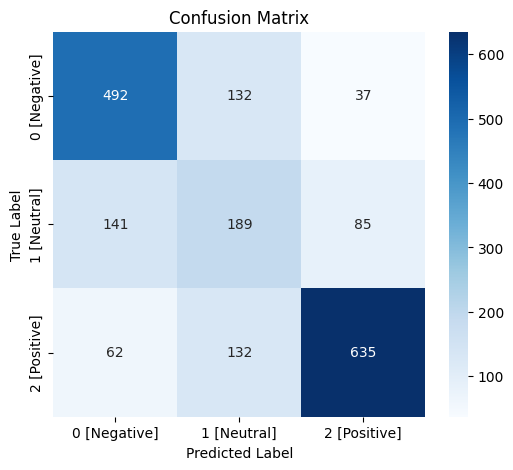

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["0 [Negative]", "1 [Neutral]", "2 [Positive]"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(model.state_dict, "data/semantic_classifier_2.pth")